# 购买品牌预测

## 1.数据读取

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
train_df=pd.read_csv('train.csv')#读取训练数据集
test_df=pd.read_csv('test.csv')#读取测试数据集
zuhao_df=pd.read_csv('组号.csv')#读取zuhao数据集

然后查看一下是否读取完成

In [2]:
train_df.head()#查看训练测试集前五个数

,salary,age,elevel,car,zipcode,credit,brand
0,119806.54480,45,0,14,4,442037.71130,0
1,78020.75094,23,0,15,2,48795.32279,0
2,50873.61880,20,3,14,4,352951.49770,0
3,72298.80402,29,4,17,0,276298.69520,0
4,128999.93560,52,1,6,0,152232.50980,0


In [3]:
test_df.head()#查看测试数据集前五个数

,salary,age,elevel,car,zipcode,credit,brand
0,28662.39571,64,4,13,8,118241.0303,0
1,68256.01678,51,3,11,7,307741.8081,0
2,130235.44560,76,1,3,0,27372.1500,0
3,88149.88200,66,4,11,4,440103.6174,0
4,90778.18681,34,4,14,3,0.0000,0


In [4]:
zuhao_df.head()

,salary,age,elevel,car,zipcode,credit,brand
0,82523.83897,51,1,8,3,141657.60660,NaN
1,83273.92858,46,3,18,6,213961.36830,NaN
2,51475.90385,66,0,15,6,82059.50124,NaN
3,60787.31789,76,0,18,4,249276.45940,NaN
4,125904.77050,42,3,7,4,459119.17030,NaN


至此，我们的数据读取完成

## 2.数据分析

我们可以先查看一下训练数据集的构成

In [5]:
train_df.count()

salary     9398
age        9398
elevel     9398
car        9398
zipcode    9398
credit     9398
brand      9398
dtype: int64

### 2.1 品牌分析

我们先查看一下brand的分布

In [6]:
train_df['brand'].value_counts()

1    5654
0    3744
Name: brand, dtype: int64

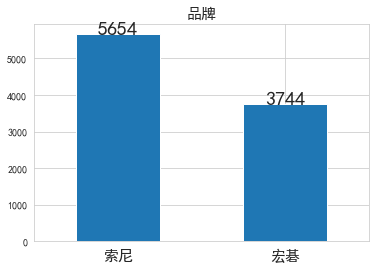

In [7]:
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
sns.set_style('whitegrid') #将背景主题设为白色网格
plt.rcParams['font.sans-serif'] = ['SimHei']#解决中文乱码问题
train_df['brand'].value_counts().plot(kind='bar') #根据人们选择的品牌画直方图，统计选择的品牌
plt.title("品牌",fontsize=15) #设置图像标题，字体大小设为15
plt.xticks([0,1],['索尼','宏碁'],rotation=0,fontsize=15)#将x坐标0、1设置成宏碁和索尼，不旋转，字体大小为15
plt.text(0,5654,5654,ha='center',fontsize=20) #加标签
plt.text(1,3744,3744,ha='center',fontsize=20) 
plt.show()  #图显示，可用%matplotlib inline替代所有

我们可以发现选择索尼的人数多于选择宏碁的人数

之后我们可以创建相关矩阵，分析一下各个特征值和最终选择品牌的关系

In [8]:
corrdata = train_df.corr()#创建训练数据集相关性矩阵
corrdata

,salary,age,elevel,car,zipcode,credit,brand
salary,1.000000,-0.003190,-0.003271,-0.006840,-0.005588,-0.023044,0.212833
age,-0.003190,1.000000,-0.004454,0.013108,0.004627,0.000995,0.017127
elevel,-0.003271,-0.004454,1.000000,-0.001313,0.019058,0.001647,-0.005682
car,-0.006840,0.013108,-0.001313,1.000000,0.002081,-0.011640,0.004230
zipcode,-0.005588,0.004627,0.019058,0.002081,1.000000,0.002645,0.001897
credit,-0.023044,0.000995,0.001647,-0.011640,0.002645,1.000000,0.004137
brand,0.212833,0.017127,-0.005682,0.004230,0.001897,0.004137,1.000000


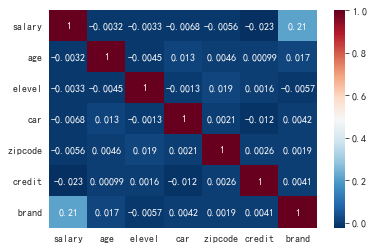

In [9]:
heatmap=sns.heatmap(corrdata,cmap="RdBu_r",annot=True)#显示出相关矩阵所形成的热力图

我们可以发现，除了工资以外，其他特征值对于品牌选择的影响都比较低

## 3.数据清洗

### 3.1 合并数据

首先，我们可以先将测试数据集和训练数据集合并为df，方便后续的数据清洗操作

In [10]:
df=train_df.append(test_df,ignore_index = True )
df=df.append(zuhao_df,ignore_index = True )

然后我们可以查看一下df的前五个值，是否正确合并

In [11]:
df.head()

,salary,age,elevel,car,zipcode,credit,brand
0,119806.54480,45,0,14,4,442037.71130,0.0
1,78020.75094,23,0,15,2,48795.32279,0.0
2,50873.61880,20,3,14,4,352951.49770,0.0
3,72298.80402,29,4,17,0,276298.69520,0.0
4,128999.93560,52,1,6,0,152232.50980,0.0


然后我们来看一下df的数据构成和缺失值情况

In [12]:
df.count()

salary     14898
age        14898
elevel     14898
car        14898
zipcode    14898
credit     14898
brand      13898
dtype: int64

In [13]:
df.isnull().sum()

salary        0
age           0
elevel        0
car           0
zipcode       0
credit        0
brand      1000
dtype: int64

我们可以发现df中没有缺失值，所以不进行缺失值处理

### 3.2 credit字段处理

我们发现credit字段中有一些字段值为0，这显然是不合理的，所以我们将进行异常值处理

经过查阅资料，我们发现影响credit的因素非常多，个人收入，固定资产，地区等等都会影响，所以我们需要考虑所有因素

因为考虑的因素较多，所以我们可以引用随机森林对credit字段的数值进行填充

In [14]:
from sklearn.ensemble import RandomForestRegressor
credit_df = df[['age', 'car','salary','credit','zipcode']]#将所有字段都作为特征值
credit_df=pd.get_dummies(credit_df)
known_credit = credit_df[credit_df.credit!=0].values
unknown_credit= credit_df[credit_df.credit==0].values
y = known_credit[:, 0]
X = known_credit[:, 1:]
rfr = RandomForestRegressor(random_state=0, n_estimators=100, n_jobs=-1)
rfr.fit(X, y)
predictedcredit = rfr.predict(unknown_credit[:, 1::])
df.loc[ (df.credit==0), 'credit' ] = predictedcredit 

我们可以检验一下是否异常的credit值已经处理完毕

In [15]:
df[df.credit==0]#查看是否有credit的值小于1000的行存在

,salary,age,elevel,car,zipcode,credit,brand


检验结果为没有credit等于0的值存在，至此，credit的异常值处理完毕

## 4.特征工程

### 4.1 age字段分类转换

我们可以发现，年龄分布较为杂乱，我们可以将其分段，10岁为一个区间进行分类

In [16]:
df['age']=df['age']//10*10  #将Age转换为以10为间隔的整数，完成分段

In [17]:
df.age

0        40
1        20
2        20
3        20
4        50
         ..
14893    60
14894    70
14895    70
14896    60
14897    20
Name: age, Length: 14898, dtype: int64

至此，age字段已经分类完成

### 4.2 salary字段分类转换

同样的，每个人的收入状况都是不同的，采取不同的数据不方便我们进行统计，所以我们进行分类操作，使其更容易统计

我们采用一万一个梯度进行分类

In [18]:
df['salary']=df['salary']//10000*10000  #将salary转换为以10000为间隔的整数，完成分段

In [19]:
df.salary

0        110000.0
1         70000.0
2         50000.0
3         70000.0
4        120000.0
           ...   
14893     20000.0
14894     80000.0
14895    120000.0
14896     90000.0
14897     20000.0
Name: salary, Length: 14898, dtype: float64

我们可以发现salary已经转换完毕

### 4.3 credit字段分类转换

由于信用额度差距过大，我们对该字段进行分类统计

由于credit中的数值差距过大，我们根据电脑价格和信用额度的比例大小进行分类转换

In [20]:
credit_1=df['credit']/10000#默认电脑大约为10000元左右
credit_1

0        44.203771
1         4.879532
2        35.295150
3        27.629870
4        15.223251
           ...    
14893     0.005183
14894    28.251191
14895    38.487136
14896    39.944670
14897    22.320465
Name: credit, Length: 14898, dtype: float64

我们会发现其中差距较大，我们将小于0.5的分为一类，0.5~1分为一类，1~5分为一类，5~25分为一类，25~50分为一类

In [21]:
df.drop('credit',axis=1)#将df中的credit先删除

,salary,age,elevel,car,zipcode,brand
0,110000.0,40,0,14,4,0.0
1,70000.0,20,0,15,2,0.0
2,50000.0,20,3,14,4,0.0
3,70000.0,20,4,17,0,0.0
4,120000.0,50,1,6,0,0.0
...,...,...,...,...,...,...
14893,20000.0,60,2,10,0,NaN
14894,80000.0,70,1,18,8,NaN
14895,120000.0,70,2,7,4,NaN
14896,90000.0,60,2,15,0,NaN


此时我们已经将credit从df中删去

我们创建一个函数，将credit_1中的数据进行分类

In [22]:
def covert_credit(credit):
    if(credit<=0.5):
        a=0
    elif(credit<=1 and credit>0.5):
        a=1
    elif(credit<=5 and credit>1):
        a=2
    elif(credit<=25 and credit>5):
        a=3
    else:
        a=4
    return a

credit_1=credit_1.map(covert_credit)#借助map函数调用covert_credit实现转换
credit_1

0        4
1        2
2        4
3        4
4        3
        ..
14893    0
14894    4
14895    4
14896    4
14897    3
Name: credit, Length: 14898, dtype: int64

我们可以发现credit_1已经转化完毕

In [23]:
df=pd.concat([df,credit_1],axis=1)#将转化好的credit_1与df合并
df

,salary,age,elevel,car,zipcode,credit,brand,credit
0,110000.0,40,0,14,4,442037.71130,0.0,4
1,70000.0,20,0,15,2,48795.32279,0.0,2
2,50000.0,20,3,14,4,352951.49770,0.0,4
3,70000.0,20,4,17,0,276298.69520,0.0,4
4,120000.0,50,1,6,0,152232.50980,0.0,3
...,...,...,...,...,...,...,...,...
14893,20000.0,60,2,10,0,51.83000,NaN,0
14894,80000.0,70,1,18,8,282511.90950,NaN,4
14895,120000.0,70,2,7,4,384871.36390,NaN,4
14896,90000.0,60,2,15,0,399446.69620,NaN,4


我们可以看到这样credit字段就转换完成

### 4.3 One-Hot编码

In [24]:
df=pd.get_dummies(df)#get_dummies可以实现数据One-hot

## 5.建立模型与求解

### 5.1 创建训练集与测试集

In [25]:
from sklearn import preprocessing
from sklearn import linear_model, svm, gaussian_process
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
import numpy as np
sourceRow=9398#原始数据集有9398行
source_y=df.loc[0:sourceRow-1,'brand']#原始数据集的结果
source_X=df.loc[train_df.index].drop('brand',axis=1).values#原始数据集：特征
pred_X=df.loc[test_df.index].drop('brand',axis=1)#预测数据集：特征
pred_y=df.loc[test_df.index]#预测数据集的结果
pred_y=pred_y['brand']
zuhao_X=df.loc[zuhao_df.index].drop('brand',axis=1)
print('原始数据集:',source_X.shape)#原始数据集
print('预测数据集:',pred_X.shape)#预测数据集
print('组号数据集:',zuhao_X.shape)#组号数据集
pred_X=pred_X.values
zuhao_X=zuhao_X.values

原始数据集: (9398, 7)
预测数据集: (4500, 7)
组号数据集: (1000, 7)


In [26]:
from sklearn.model_selection import train_test_split

#建立模型用的训练数据集和测试数据集
train_X, test_X, train_y, test_y = train_test_split(source_X ,
                                                    source_y,
                                                    train_size=.8)

### 5.2 随机森林模型的建立

我们先应用网格化来自动化寻找最适宜的max_depth和n_estimators参数

In [27]:
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import SelectKBest

pipe=Pipeline([('select',SelectKBest(k='all')), 
               ('classify', RandomForestClassifier(random_state = 10, max_features = 'sqrt'))])

param_test = {'classify__n_estimators':list(range(20,50,2)), 
              'classify__max_depth':list(range(3,60,3))}
gsearch = GridSearchCV(estimator = pipe, param_grid = param_test, scoring='roc_auc', cv=10)
gsearch.fit(source_X,source_y)#通过拟合训练集来找到最适合的参数
print(gsearch.best_params_, gsearch.best_score_)

KeyboardInterrupt: 

之后我们将所求出的最优化的参数带入并且训练模型

In [28]:
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import SelectKBest
from sklearn.pipeline import make_pipeline
select = SelectKBest(k = 'all')
clf = RandomForestClassifier(random_state = 10, warm_start = True, #命名
                                  n_estimators = 48,#将自动化寻找到的最优参数代入模型
                                  max_depth = 12, 
                                  max_features = 'sqrt')
pipeline = make_pipeline(select, clf)#拟合
pipeline.fit(source_X, source_y)#将训练集带入拟合

Pipeline(steps=[('selectkbest', SelectKBest(k='all')),
                ('randomforestclassifier',
                 RandomForestClassifier(max_depth=12, max_features='sqrt',
                                        n_estimators=48, random_state=10,
                                        warm_start=True))])

### 5.3 模型调整与求解

训练完模型之后将训练集带入模型进行拟合，并通过交叉验证得出得分

In [29]:
from sklearn import model_selection, metrics
cv_score = model_selection.cross_val_score(clf,source_X,source_y, cv= 10)#将训练集带入模型求解，交叉验证求出结果
print("CV Score : Mean - %.7g | Std - %.7g " % (np.mean(cv_score), np.std(cv_score)))

CV Score : Mean - 0.8997671 | Std - 0.006290836 


之后将测试集带入模型拟合并通过交叉验证得出得分

In [30]:
from sklearn import model_selection, metrics
cv_score = model_selection.cross_val_score(clf,pred_X,pred_y, cv= 10)#将测试集集带入模型求解，交叉验证求出结果
print("CV Score : Mean - %.7g | Std - %.7g " % (np.mean(cv_score), np.std(cv_score)))#交叉验证

CV Score : Mean - 0.9093333 | Std - 0.01027042 


然后我们使用普通验证进行测试集预测结果准确度的验证

In [31]:
model1=RandomForestClassifier(n_estimators=48,max_depth=12,random_state=0)#建立模型进行普通验证
model1.fit(source_X,source_y)#将model1进行拟合学习
model1.score(pred_X,pred_y)#通过score函数得出相似度

0.9528888888888889

最后，将我们需要求解的zuhao_X带入模型，得到最终的答案

In [ ]:
predictions = pipeline.predict(zuhao_X)#将zuhao_X带入模型得出结果
submission = pd.DataFrame({ "brand": predictions.astype(np.int32)})#将模型求解出的结果放入一个有brand字段的数据框
submission.to_csv('jieguo1.csv', index=False)#将结果输出成jieguo1.csv